In [35]:
import pandas as pd

import shap

import mlflow
from mlflow.tracking import MlflowClient

from time import time

from utils.grid_search import generate_combination
from utils.log_utils import calculate_elapsed_time
from utils.ml_utils import create_experiment
from utils.file_utils import save_model
from utils.report_utils import feature_importance, shap_report

from dataset.make_dataset import make_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [36]:
wine_df = make_dataset()

x = wine_df.drop(columns=['quality'])
y = wine_df['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [37]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.43477083333333333

In [38]:
param_grid = {
    'n_jobs': [-1],
    'n_estimators': list(range(50, 250, 50)),
    'max_depth': [None, 10, 20],
    'min_samples_split': list(range(2, 10, 4)),
    'min_samples_leaf': list(range(1, 10, 4)),
}

params_list = generate_combination(param_grid)
param_grid


{'n_jobs': [-1],
 'n_estimators': [50, 100, 150, 200],
 'max_depth': [None, 10, 20],
 'min_samples_split': [2, 6],
 'min_samples_leaf': [1, 5, 9]}

In [39]:
total_itter = len(params_list)

itter_template = '{:<' + str(len(str(total_itter))) + '}'

log_table = f'{itter_template} / {itter_template}' + " | Error: {:<5.4f} | Elapsed Time: {:<6} | Total Time: {:<6}"


1  / 72 | Error: 0.4409 | Elapsed Time: 4.106s | Total Time: 4.124s
2  / 72 | Error: 0.4619 | Elapsed Time: 2.976s | Total Time: 7.120s
3  / 72 | Error: 0.4768 | Elapsed Time: 2.851s | Total Time: 9.990s
4  / 72 | Error: 0.4464 | Elapsed Time: 3.594s | Total Time: 13.602s
5  / 72 | Error: 0.4638 | Elapsed Time: 3.333s | Total Time: 16.955s
6  / 72 | Error: 0.4879 | Elapsed Time: 3.165s | Total Time: 20.137s
7  / 72 | Error: 0.4565 | Elapsed Time: 3.684s | Total Time: 23.842s


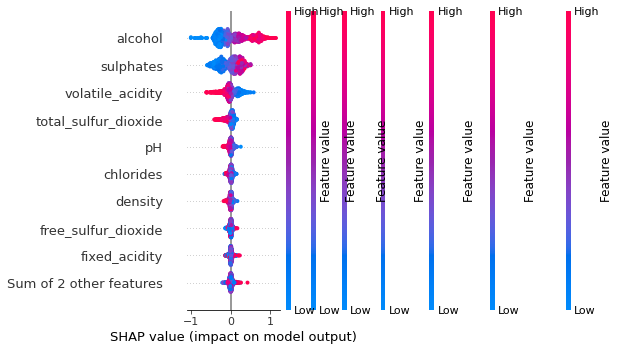

In [40]:

exp = create_experiment('Regression Approaches')

client = MlflowClient()


hist = []

ini_exp = time()
for i, params in enumerate(params_list):
    with mlflow.start_run(experiment_id=exp.experiment_id):
        ini = time()

        # Train
        model = RandomForestRegressor(**params)
        model.fit(x_train, y_train)
        save_model(model, path='bin/')

        fi_path = feature_importance(model, x_train)

        # Predict
        y_pred = model.predict(x_test)
        error = mean_absolute_error(y_test, y_pred)

        shap_test = shap_report(model, x_test, show=False)

        for key in params.keys():
            mlflow.log_param(key, params[key])

        mlflow.log_metric('MAE', error)

        mlflow.log_artifact(fi_path)
        mlflow.log_artifact(shap_test)

        mlflow.sklearn.log_model(model, "bin")

        print(log_table.format(i + 1, total_itter, error, calculate_elapsed_time(ini), calculate_elapsed_time(ini_exp)))

        hist.append([error, params])

    if i > 5:
        break


In [41]:
hist = sorted(hist, key=lambda x: x[0], reverse=True)
best_param = hist[0][1]
best_param

{'n_jobs': -1,
 'n_estimators': 50,
 'max_depth': None,
 'min_samples_split': 6,
 'min_samples_leaf': 9}

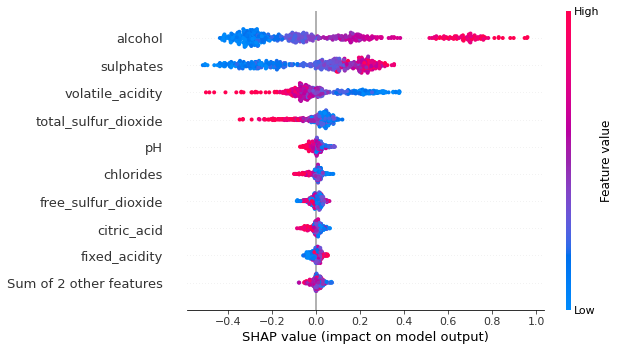

'result/shap.png'

In [42]:
# Train
model = RandomForestRegressor(**best_param)
model.fit(x_train, y_train)
save_model(model, path='bin/')

fi_path = feature_importance(model, x_train)

# Predict
y_pred = model.predict(x_test)
error = mean_absolute_error(y_test, y_pred)


shap_report(model, x_test, show=True)

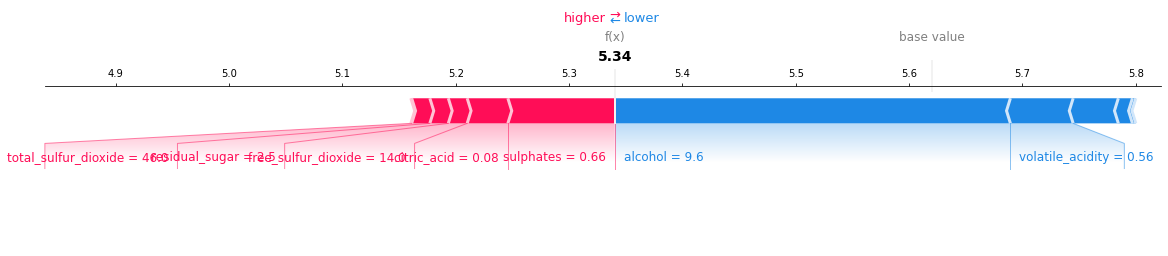

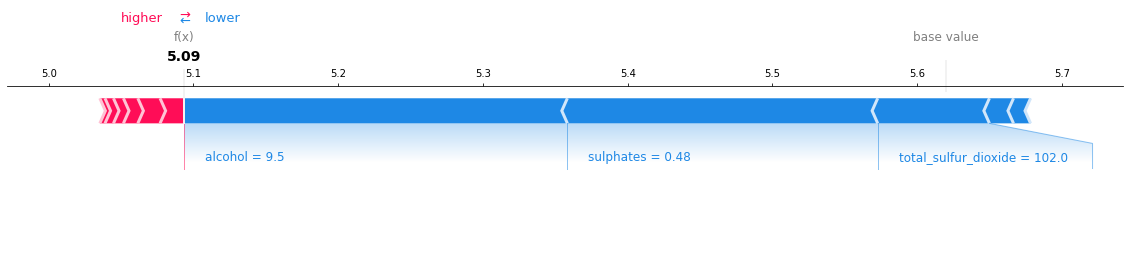

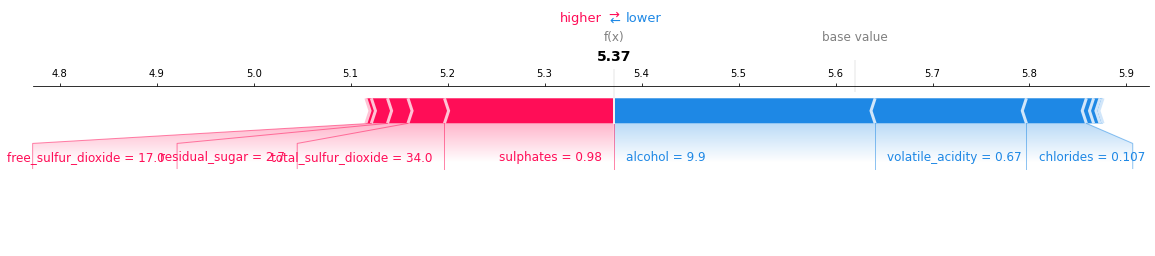

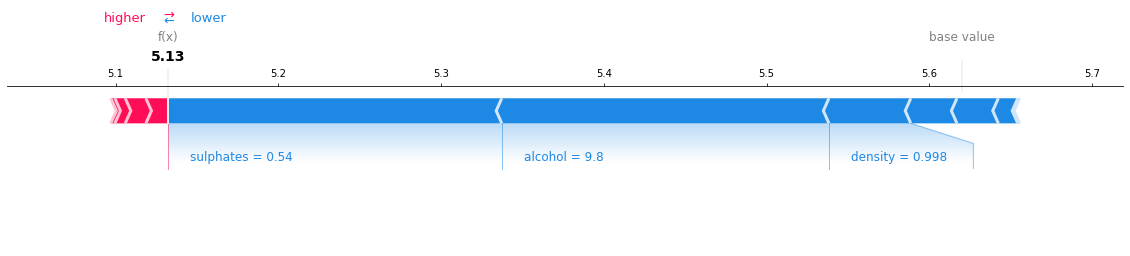

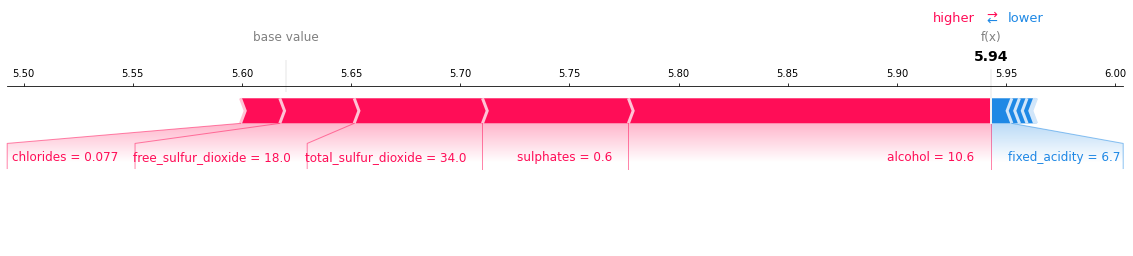

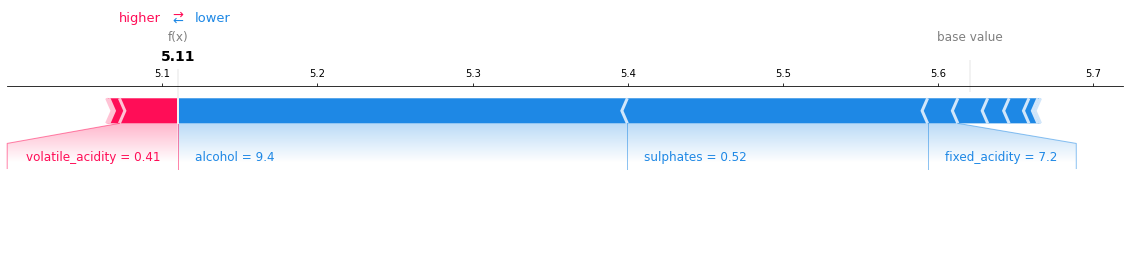

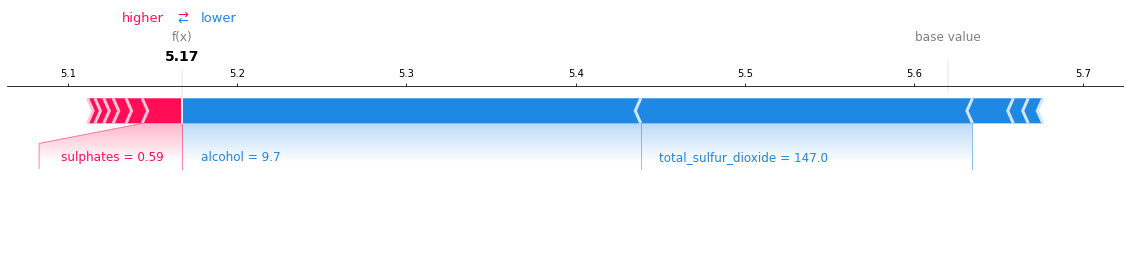

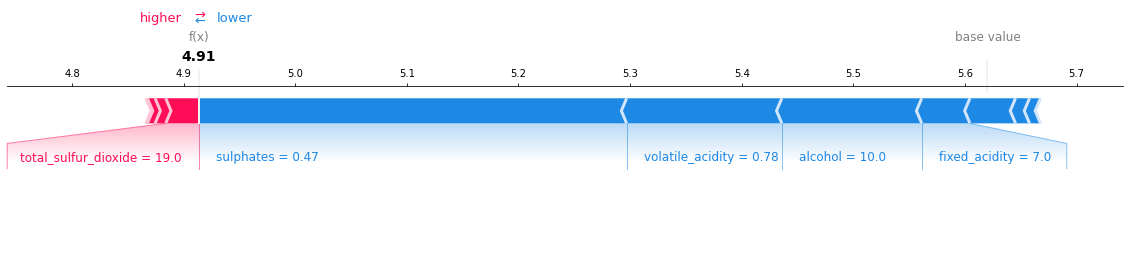

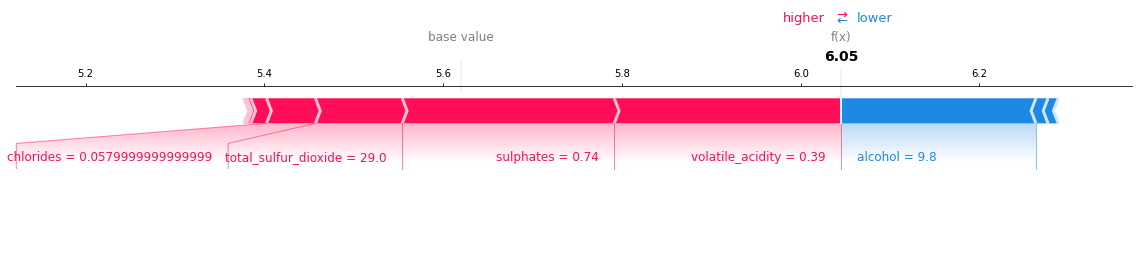

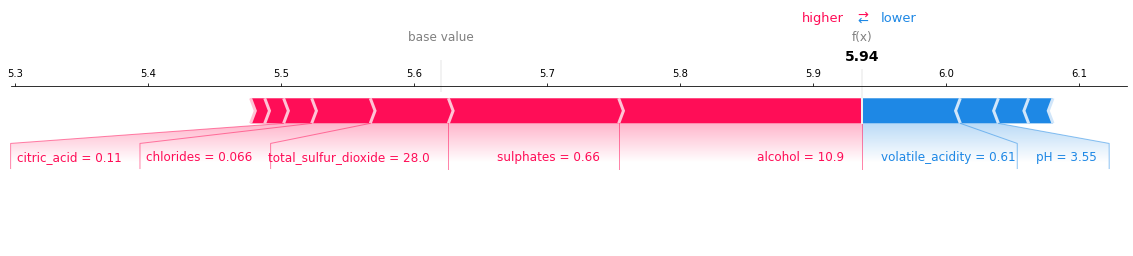

In [71]:


for i in range(10):

    sample = pd.DataFrame(x_test.iloc[i]).T

    explainer = shap.Explainer(model)
    shap_values = explainer(sample)

    shap.plots.force(shap_values[0], matplotlib=True)